### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [10]:
import matplotlib.pyplot as plt

In [1]:
############################################
############################################
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import collections
import hashlib
import numbers

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim
###########################################
###### variables used in the model ########
###########################################

_SYNAPTIC_DELAY_NAME="synaptic_delay"
_INPUT_DELAY_NAME="input_delay"


###########################################
###### functions used in the model ########
###########################################

def _delay_initializer(shape,dtype=None,partition_info=None,verify_shape=None, max_val=5):
    if dtype is None:
        dtype=tf.float32
    return tf.cast(tf.random_uniform(shape,1,max_val,dtype=tf.int32),dtype)
    #return tf.cast(2*tf.ones(shape,dtype=tf.int32),dtype)

@tf.custom_gradient
def _calcualte_crossings(x):
    """input :x : a 2D tensor with batch x n
    outputs a tensor with the same size as x
    and values of 0 or 1 depending on comparison between
    x and threshold"""
    dtype=x.dtype
    res=tf.greater_equal(x,0.0)
    def grad(dy):
        # calculate 1-|x|
        temp=1-tf.abs(x)
        dyres=tf.scalar_mul(0.3,tf.maximum(temp,0.0))
        return dyres
    return tf.cast(res,dtype=dtype), grad

def _get_input_spike(S,spike,delay_tensor,depth):
    """input - x : a 3D tensor with batch x delay x n , and a 2D tensor batch x n
    outputs a tensor with size batch x output_size, where outputsize is twice the size of thresholds_size
    """
    # roll S and get new input,
    S_update=tf.roll(S,shift=-1,axis=1)
    new_input=S_update[:,0,:]
    synaptic_shape=tf.shape(S)
    # add new spikes to S
    correction_mat=tf.expand_dims(tf.concat([tf.ones([synaptic_shape[1]-1,synaptic_shape[2]],tf.float32),tf.zeros([1,synaptic_shape[2]],dtype=tf.float32)],axis=0),axis=0)
    S_cut=tf.multiply(S_update,correction_mat)
    # add spikes to S_cut
    spike_tensor=tf.multiply(tf.expand_dims(tf.cast(spike,tf.float32),axis=-2),tf.one_hot(tf.cast(tf.multiply(delay_tensor,spike),tf.int32),depth=depth+1,axis=1))
    # update S and return output
    S_out=tf.add(S_cut,spike_tensor)
    return S_out, new_input


###########################################
###### definition of tuples for cells #####
###########################################
_LSNNStateTuple = collections.namedtuple("LSNNStateTuple", ("v_mem","spike","S_in","S_rec","b_threshold","t_reset"))
_LSNNOutputTuple = collections.namedtuple("LSNNOutputTuple", ("v_mem","spike","S_in","S_rec","I_in","I_rec","b_threshold","t_reset"))

class LSNNStateTuple(_LSNNStateTuple):
  """Tuple used by LSNN Cells for `state_variables `, and output state.
  Stores five elements: `(v_mem,spike, t_reset, I_syn)`, in that order. Where `v_mem` is the hidden state
  , spike is output, `S_rec` and 'S_in' are spike history, and t_reset refractory history.
  Only used when `state_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem,spike,S_in,S_rec,b_threshold,t_reset) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype
class LSNNOutputTuple(_LSNNOutputTuple):
  """Tuple used by SNN Cells for output state.
  Stores six elements: `(v_mem,spike,t_reset,I_syn)`,
  Only used when `output_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem,spike,S_in,S_rec,I_in,I_rec,b_threshold,t_reset) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype

###########################################
### define long_short_term_spike_cell #####
###########################################


class long_short_term_spike_cell(tf.contrib.rnn.RNNCell):
  """ long_short_term_spike_Cell
  Args:
  """
  def __init__(self,
               num_units,
               num_inputs,
               tau_m=20.0,
               v_theta=1.0,
               v_reset=0.0,
               R_mem=2.0,
               tau_s=5.0,
               tau_refract=1.0,
               tau_beta=1.0,
               dt=1.0,
               beta_baseline=1.0,
               beta_coeff=0.1,
               activation=None,
               reuse=None,
               max_input_delay=4,
               max_synapse_delay=4, 
               input_delay_initializer=None,
               synaptic_delay_initializer=None,
               kernel_initializer=None,
               bias_initializer=None,
               state_is_tuple=True,
               output_is_tuple=False):
    super(long_short_term_spike_cell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self._num_inputs = num_inputs
    self.max_input_delay=max_input_delay
    self.max_synapse_delay=max_synapse_delay
    self.tau_m=tau_m
    self.v_theta=v_theta
    self.v_reset=v_reset
    self.R_mem=R_mem
    self.tau_s=tau_s
    self.tau_refract=tau_refract
    self.tau_beta=tau_beta
    self.dt=dt
    self.beta_baseline=beta_baseline
    self.beta_coeff=beta_coeff
    self.kernel_factor=np.divide(self.dt,np.multiply(self.R_mem,np.sqrt(self._num_units)))
    self._linear = None
    self._kernel_initializer = kernel_initializer
    self._bias_initializer = bias_initializer
    self._synaptic_delay_initializer=synaptic_delay_initializer
    self._input_delay_initializer=input_delay_initializer
    self._state_is_tuple= state_is_tuple
    self._output_is_tuple= output_is_tuple
    self._calculate_crossing= _calcualte_crossings
    self._get_input_spike=_get_input_spike
    self._delay_initializer=_delay_initializer

# create intializers
    if kernel_initializer is None:
        self._kernel_initializer=tf.initializers.random_normal(mean=0,stddev=1/self.kernel_factor)
    else:
        self._kernel_initializer=kernel_initializer

    if synaptic_delay_initializer is None:
        self._synaptic_delay_initializer= self._delay_initializer
    else:
        self._synaptic_delay_initializer=synaptic_delay_initializer

    if input_delay_initializer is None:
        self._input_delay_initializer= self._delay_initializer
    else:
        self._input_delay_initializer=input_delay_initializer



  @property
  def state_size(self):
    return (LSNNStateTuple(self._num_units,
                          self._num_units,
                          np.array([self.max_input_delay+1,self._num_inputs]),
                          np.array([self.max_synapse_delay+1,self._num_units]),
                          self._num_units,
                          self._num_units) if self._state_is_tuple else self._num_units)
  @property
  def output_size(self):
    return (LSNNOutputTuple(self._num_units,
                          self._num_units,
                          np.array([self.max_input_delay+1,self._num_inputs]),
                          np.array([self.max_synapse_delay+1,self._num_units]),
                          self._num_inputs,
                          self._num_units,
                          self._num_units,
                          self._num_units) if self._output_is_tuple else self._num_units)

  def call(self, inputs, state):
    """ (conductance_spike_Cell call function).
    Args:
        inputs: `2-D` tensor with shape `[batch_size x input_size]`.
        state: An `LSSNStateTuple` of state tensors, shaped as following
          v_mem:            [batch_size x self.state_size]`
          spike:            [batch_size x self.state_size]`
          S:                [self._num_units+self._num_inputs,self.synaptic_delay[-1]]`
          b_threshold       [batch_size x self.state_size]`
          t_reset           [batch_size x self.state_size]`
    Returns:
      A pair containing the new output, and the new state as SNNStateTuple
    """
    scope=vs.get_variable_scope()
    with vs.variable_scope(scope,initializer= self._synaptic_delay_initializer) as synaptic_delay_scope:
        synaptic_delay_tensor=tf.get_variable(_SYNAPTIC_DELAY_NAME,shape=[self._num_units],dtype=tf.float32,trainable=False)

    scope=vs.get_variable_scope()
    with vs.variable_scope(scope,initializer= self._input_delay_initializer) as _input_delay_initializer:
        input_delay_tensor=tf.get_variable(_INPUT_DELAY_NAME,shape=[self._num_inputs],dtype=tf.float32,trainable=False)


    if self._state_is_tuple:
        v_mem,spike,S_in,S_rec,b_threshold,t_reset = state
    else:
        logging.error("this cell only accept state as tuple ", self)
    # determine the spike which gets integrated

    S_in_new, I_in = self._get_input_spike(S_in,inputs,input_delay_tensor,self.max_input_delay)
    S_rec_new, I_rec = self._get_input_spike(S_rec,spike,synaptic_delay_tensor,self.max_synapse_delay)

    if self._linear is None:
        self._linear = _Linear([I_in,I_rec],self._num_units,False,
                                    kernel_initializer=self._kernel_initializer,
                                    bias_initializer=self._bias_initializer)

    # compute outputs and states
    I_syn=self._linear([I_in,I_rec])
    alpha=tf.exp(tf.negative(tf.divide(self.dt,self.tau_m)))
    rho=tf.exp(tf.negative(tf.divide(self.dt,self.tau_beta)))
    Beta= self.beta_baseline + tf.multiply(self.beta_coeff,b_threshold)
    eligilible_update=tf.cast(tf.less(t_reset,self.dt),tf.float32)
    not_eligilible_update=1-eligilible_update
    # modify alpha so that only affect neurons that are beyond their refractory period
    alpha_vec=tf.scalar_mul(alpha,eligilible_update)+not_eligilible_update
    v_mem_update=tf.add(tf.multiply(alpha_vec,v_mem),tf.multiply(tf.multiply(1-alpha_vec,self.R_mem),I_syn))
    v_mem_norm=tf.divide(tf.subtract(v_mem_update,Beta),Beta)
    spike_new=self._calculate_crossing(v_mem_norm)
    v_reseting=tf.multiply(v_mem_update,spike_new)
    v_mem_new=tf.subtract(v_mem_update,v_reseting)
    b_threshold_new = tf.add(tf.scalar_mul(rho,b_threshold), tf.scalar_mul(1-rho,spike))
    t_update=tf.clip_by_value(tf.subtract(t_reset,self.dt),0.0,100)
    t_reset_new=tf.add(tf.multiply(spike_new,self.tau_refract),t_update)
    # return variables
    if self._state_is_tuple:
        new_state = LSNNStateTuple( v_mem_new,spike_new, S_in_new,S_rec_new, b_threshold_new, t_reset_new )
    if self._output_is_tuple:
        new_output = LSNNOutputTuple( v_mem_new,spike_new, S_in_new,S_rec_new,I_in,I_rec, b_threshold_new, t_reset_new )
    else:
        new_output = spike_new
    return new_output, new_state



first testing the code on a constant input 

rnn/long_short_term_spike_cell/synaptic_delay:0 [2.]
rnn/long_short_term_spike_cell/input_delay:0 [2.]
rnn/long_short_term_spike_cell/kernel:0 [[1.]
 [1.]]


Text(0.5, 1.0, 'input_current')

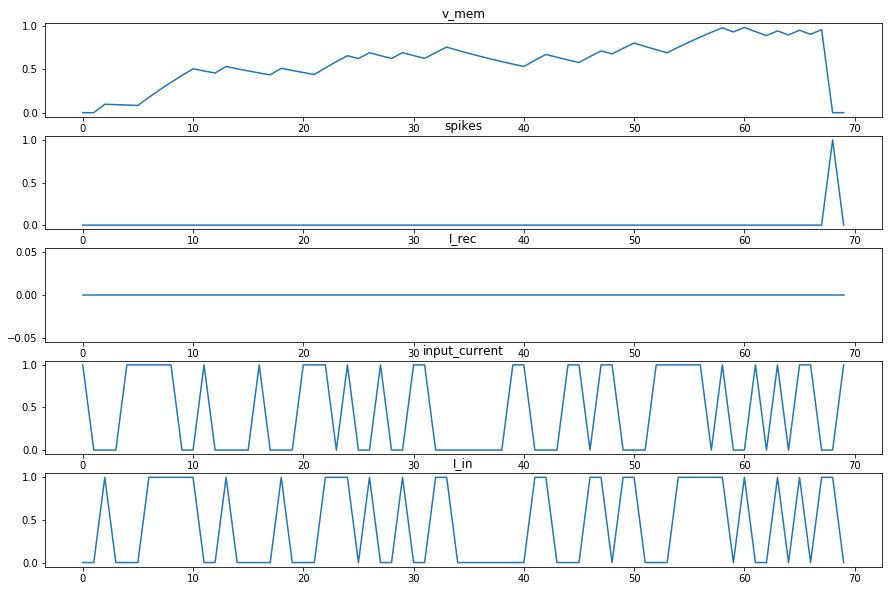

In [225]:
batch_size = 1
sequence_length = 70
num_inputs=1
num_units=1
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNN_cell = long_short_term_spike_cell(num_units=num_units,num_inputs=num_inputs,state_is_tuple=True,output_is_tuple=True,
                    kernel_initializer=tf.initializers.ones())
outputs, state = tf.nn.dynamic_rnn(cell=LSNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])
    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,10])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.flatten())
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.spike.flatten())
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(output_run.I_rec.flatten())
ax.set_title('I_rec')
ax=plt.subplot(5,1,5)
ax.plot(output_run.I_in.flatten())
ax.set_title('I_in')
ax=plt.subplot(5,1,4)
ax.plot(input_spikes.flatten())
ax.set_title('input_current')

next we create a recurrent version to verify the functionality 

rnn/long_short_term_spike_cell/synaptic_delay:0 [2. 2.]
rnn/long_short_term_spike_cell/input_delay:0 [3. 2.]
rnn/long_short_term_spike_cell/kernel:0 [[-0.42966944 -0.4673328 ]
 [ 1.4214147   1.7839717 ]
 [-0.06592048  0.14534968]
 [ 0.02412664 -0.00595857]]


Text(0.5, 1.0, 'input_current')

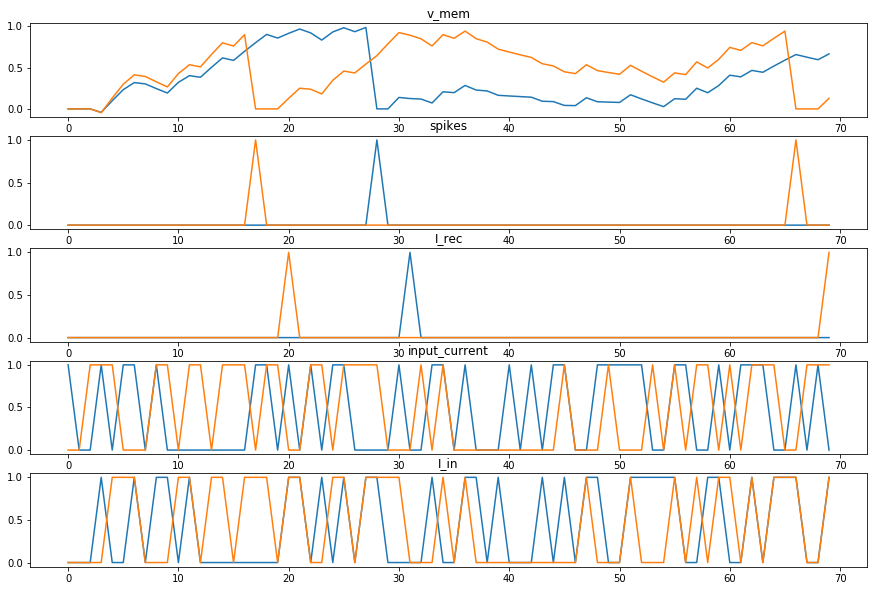

In [231]:
batch_size = 1
sequence_length = 70
num_inputs=2
num_units=2
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNN_cell = long_short_term_spike_cell(num_units=num_units,num_inputs=num_inputs,state_is_tuple=True,output_is_tuple=True,
                    kernel_initializer=tf.initializers.random_normal())
outputs, state = tf.nn.dynamic_rnn(cell=LSNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])
    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,10])
ax=plt.subplot(5,1,1)
ax.plot(np.squeeze(output_run.v_mem,axis=0))
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(np.squeeze(output_run.spike,axis=0))
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(np.squeeze(output_run.I_rec,axis=0))
ax.set_title('I_rec')
ax=plt.subplot(5,1,5)
ax.plot(np.squeeze(output_run.I_in,axis=0))
ax.set_title('I_in')
ax=plt.subplot(5,1,4)
ax.plot(np.squeeze(input_spikes,axis=0))
ax.set_title('input_current')

In [171]:
np.squeeze(output_run.S_in,axis=0).shape

(70, 5, 1)

rnn/long_short_term_spike_cell/synaptic_delay:0 [2. 1.]
rnn/long_short_term_spike_cell/input_delay:0 [2. 4.]
rnn/long_short_term_spike_cell/kernel:0 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


Text(0.5, 1.0, 'input_current')

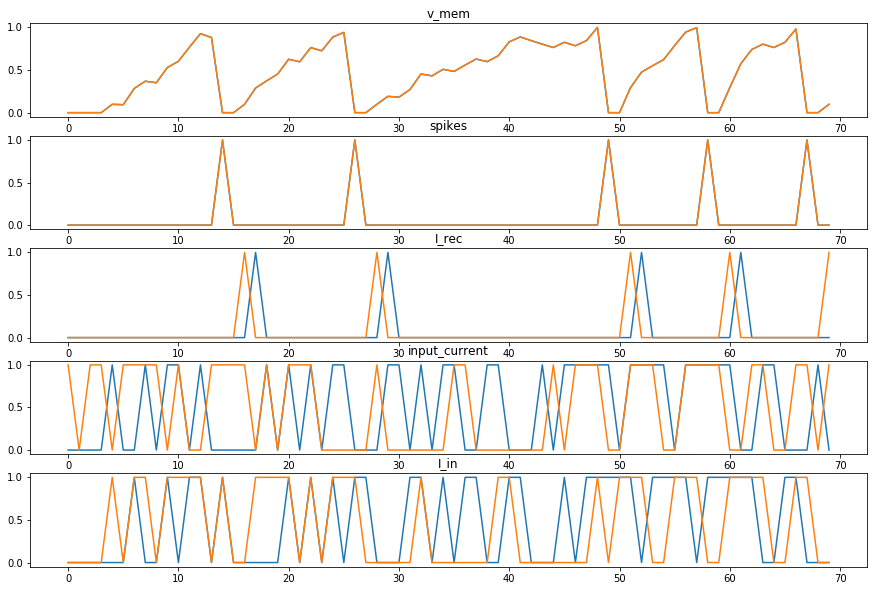

In [239]:
batch_size = 10
sequence_length = 70
num_inputs=2
num_units=2
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNN_cell = long_short_term_spike_cell(num_units=num_units,num_inputs=num_inputs,state_is_tuple=True,output_is_tuple=True,
                    kernel_initializer=tf.initializers.ones())
outputs, state = tf.nn.dynamic_rnn(cell=LSNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])
    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 

v_mem=output_run.v_mem[3,:,:]
spike=output_run.spike[3,:,:]
I_rec=output_run.I_rec[3,:,:]
I_in=output_run.I_in[3,:,:]
plt.figure(figsize=[15,10])
ax=plt.subplot(5,1,1)
ax.plot((v_mem))
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(spike)
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(I_rec)
ax.set_title('I_rec')
ax=plt.subplot(5,1,5)
ax.plot(I_in)
ax.set_title('I_in')
ax=plt.subplot(5,1,4)
ax.plot(input_spikes[3,:,:])
ax.set_title('input_current')

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.06844572,  0.12847131],
       [-0.1319381 ,  0.2831222 ],
       [-0.1255034 ,  0.2693142 ],
       [-0.18782826,  0.38465092],
       [-0.17866777,  0.36589128],
       [-0.16833885,  0.38049176],
       [-0.15851368,  0.39438015],
       [-0.2176134 ,  0.53606254],
       [-0.20700027,  0.50991845],
       [-0.26535046,  0.61352074],
       [-0.25240916,  0.583599  ],
       [-0.23848383,  0.5875817 ],
       [-0.22523765,  0.5913702 ],
       [-0.2126375 ,  0.594974  ],
       [-0.20226705,  0.5659568 ],
       [-0.2592329 ,  0.69927126],
       [-0.3150357 ,  0.7936387 ],
       [-0.29805604,  0.7873777 ],
       [-0.2835197 ,  0.7489769 ],
       [-0.26969227,  0.7124489 ],
       [-0.32336974,  0.8386189 ],
       [-0.30598363,  0.8301642 ],
       [-0.28944546,  0.8221218 ],
       [-0.27371386,  0.81447166],
       [-0.3288104 ,  0.9032208 ],
       [-0.38121983,  0.9876415 ],
       [-0.42945805,